### Bayesian Data Analysis, 3rd ed
##  Chapter 3, demo 6

Illustrate posterior inference for Bioassay data (BDA3 p. 74-).

#### Instructions for exercise (3.11 in BDA3)
- Check that the range and spacing of A and B are sensible for the 
  alternative prior
- Compute the log-posterior in a grid
- Scale the log-posterior by subtracting its maximum value before
  exponentiating (think why this is useful)
- Exponentiate
- Normalize the posterior
- Use 2D grid sampling 
- In addition to the plots, report p(beta>0|x,y)

In [1]:
import numpy as np
from scipy.special import expit  # aka logistic

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [3]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [4]:
# seed a random state
rng = np.random.RandomState(0)

In [5]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

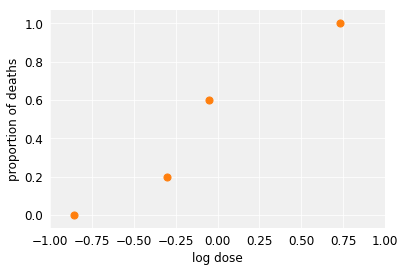

In [6]:
# plot the data
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

In [7]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
A = np.linspace(-4, 8, 100)
B = np.linspace(-10, 40, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

The following demonstrates an alternative "bad" way of calcuting the posterior density p in a for loop. The vectorised statement above is numerically more efficient. In this small example however, it would not matter that much.

```python
p = np.empty((len(B),len(A))) # allocate space
for i in range(len(A)):
    for j in range(len(B)):
        ilogit_abx_ij = (1 / (np.exp(-(A[i] + B[j] * x)) + 1))
        p[j,i] = np.prod(ilogit_abx_ij**y * (1 - ilogit_abx_ij)**(n - y))
```

N.B. the vectorised expression could be made even more efficient, e.g. by optimising memory usage with in-place statements. However, it would result in a less readable code and it is not necessary here.

In [8]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (rng.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (rng.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]

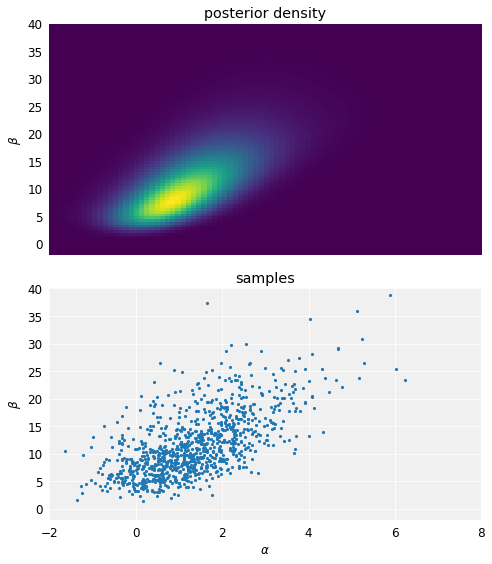

In [9]:
# create figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot the posterior density
ax = axes[0]
ax.imshow(p, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(samp_A, samp_B, 10, linewidth=0)
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

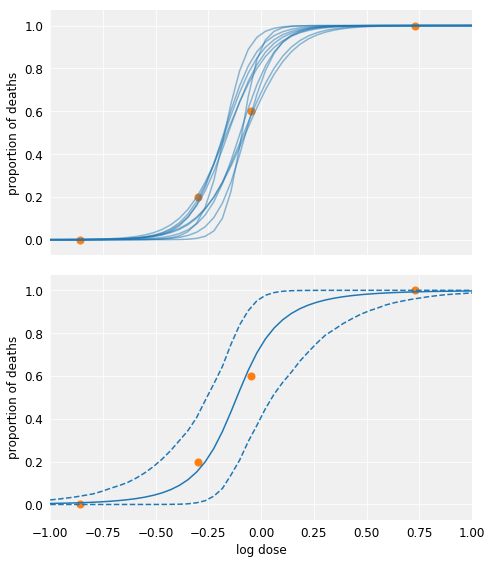

In [10]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# plot mean and [5% 95%] interval
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

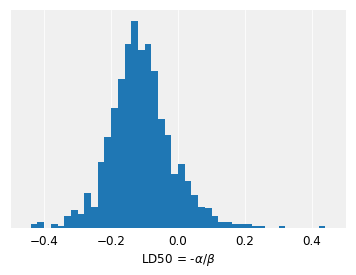

In [11]:
# plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());